## Chapter 1.2: Creating models from scratch in GemPy
***
So far we have shown the basics to create geological models by importing data from an external source (in especial GeoModeller 3D). In this chapter, we will explore the option available in GemPy to create the data directly in GemPy or to modify existing one. In this respect we will delve into the pandas DataFrames that contain the necessary data.

Let's start as always by importing the necessary dependencies:

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
#%matplotlib inline


# Aux imports
import numpy as np
import pandas as pn
import matplotlib
import theano

../../gempy/posterior_analysis.py:28: UserWarning: pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.")


### GemPy DataFrames

The class `gempy.InputData` works as the parent container of our project. Therefore the main step of any project is to create an instance of this class. In the official documentation we use normally geo_data as name of this instance. We will need to pass at least the extent (boundaries) of the project to instantiate the class:

In [2]:
geo_data = gp.InputData([0, 1000, 0, 1000, -1000, 0], [50, 50, 50])

In [3]:
geo_data.extent

array([    0,  1000,     0,  1000, -1000,     0])

In [4]:
geo_data.faults

isFault
Default series    False

Once we create the object, we will generate a number of `pandas.DataFrame` that will contain specific data structures. Lets go through these tables:

**1) Interfaces and orientations**

These two DataFrames (df from now on) will contain the individual information of each point at an interface or orientation. Some properties of this table are mapped from the *df* below.

In [5]:
# Basement is generated automatically and wont interfere with the computation
# of the model
gp.get_data(geo_data, 'interfaces')

X    Y       Z formation          series  formation_number  order_series  \
0  0.0  0.0 -1000.0  basement  Default series                 1           0.0   

   isFault  
0    False

In [6]:
gp.get_data(geo_data, 'orientations')

Empty DataFrame
Columns: [X, Y, Z, G_x, G_y, G_z, dip, azimuth, polarity, formation, series, formation_number, order_series, isFault]
Index: []

**2) Formations and series**

The *df* formation contain two properties. *Formation number* refers to the order of the formation on the sequential pile, i.e. the strict order of computation. *value* on the other hand is the final value that each voxel will have after discretization. This may be useful for example in the case we want to map a specific geophysical property (such as density) to a given unity. By default both are the same since to discretize lithological units the value is arbitrary.

In [7]:
gp.get_data(geo_data, 'formations')

value  formation_number
basement      1                 1

Series is used to define which formations (layer) belongs to which *series*. Notice that the name *series* in GemPy not only refers to stratigraphic series to model uncomformities but also faults since computationally they also require it own interpolation step.

In [8]:
gp.get_data(geo_data, 'series')

Default series
0       basement

The *series df* can be directly visualized and manipulated with the sequential pile:

../../gempy/plotting/sequential_pile.py:136: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  pos_anch = np.squeeze(self.anch_series.as_matrix())
../../gempy/plotting/sequential_pile.py:156: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  pos_anch = np.squeeze(self.anch_formations.as_matrix())


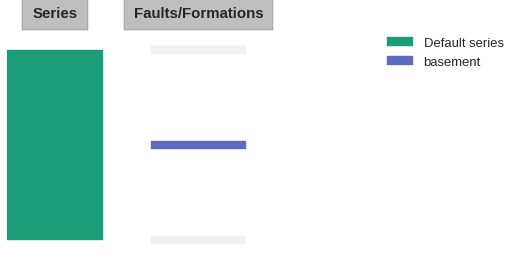

In [9]:
gp.get_sequential_pile(geo_data)

**3) Faults**

The *df faults* is used to charectirize which *mathematical series* behave as fault and if mentioned faults are finite or infinite:

In [10]:
gp.get_data(geo_data, 'faults')

isFault
Default series    False

Finally we have the *faults relations df* which captures which *mathematical series* a given fault offset in order to reproduce complex faulting networks

In [11]:
gp.get_data(geo_data, 'faults_relations')

Default series
Default series           False

`pandas` offers a rich number of functions to manipulate these *df* accordingly to our needs and produce any type of model. However, we are not in 2016 anymore. Welcome to Qgrid:

### Using Qgrid for interactive DataFrames

From its documentation :

> Qgrid is a Jupyter notebook widget which uses SlickGrid to render pandas DataFrames within a Jupyter notebook. This allows you to explore your DataFrames with intuitive scrolling, sorting, and filtering controls, as well as edit your DataFrames by double clicking cells.

In practice these library allows us to use `pandas.DataFrames` in Jupyter Notebooks as an excel table. Be aware that `Qgrid` requires of enabling nbextensions so it is important to test that the installation (https://github.com/quantopian/qgrid) was successful before trying to execute the rest of the notebook.

By calling `gempy.interactive_df_open` and passing the dataframe we want to modify we can manipulate the *df* interactivelly. But first we need to define some *formations* since basement
does not get involved in the computation of the model:

In [12]:
gp.set_formations(geo_data, formations=['layer1', 'layer2'])

value  formation_number
layer1        1                 1
layer2        2                 2
basement      3                 3

In [13]:
geo_data.interfaces

X    Y       Z formation          series  formation_number  order_series  \
0  0.0  0.0 -1000.0  basement  Default series                 3           0.0   

   isFault                       annotations  formation_value  
0    False  ${\bf{x}}_{\alpha \,{\bf{1}},0}$                3

In [17]:
gp.interactive_df_open(geo_data, 'interfaces')

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Couple of things to notice:

1) The *df* does not display all the changes that happen when we modify a field (i.e. if we change the formation to layer 1, the formation_number should be 1). However, under the hood these changes are happening and if you save the *df* you will see all as it is supossed to be.

2) The *df* in geo_data does not get updated in real time. If you want to save the changes you need to use the following function. This returns a copy of the modified *df*

In [18]:
# To set the new df we use the function set_interfaces
gp.set_interfaces(geo_data, gp.interactive_df_change_df(geo_data))

../../gempy/data_management.py:819: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  for i in self.interfaces["formation"]]


<IPython.core.display.Javascript object>


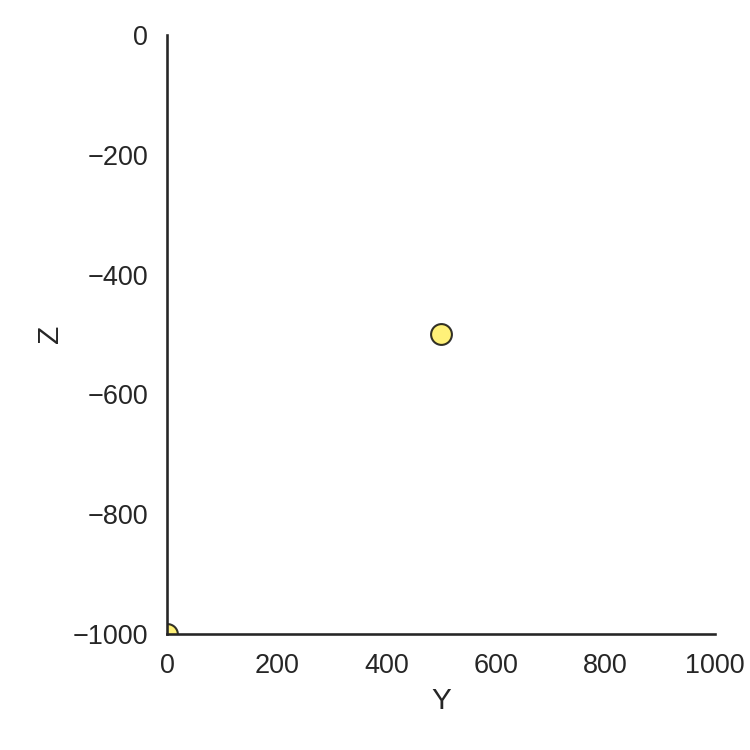

In [19]:
%matplotlib notebook
gp.plotting.plot_data(geo_data, direction='x')

Cool isn't it. Now writing new data and in special editing it is not so tiresome... however... we are not in 2017. Welcome to interactive *df* with interactive plotting:

### Bringing all together: Real time plotting- Real time DataFrames

Now that we have seen how Qgrid is integrated with GemPy we can the interactivity of vtk and the df. Lets start over a `geo_data` object.


In [22]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")
import gempy as gp
geo_data = gp.InputData([0, 1000, 0, 1000, -1000, 0], [50, 50, 50])

Next we can directly compile an `interp_data` objects. However, theano requires at least an interface and orientation. If we try to compile an empty `geo_data`, `GemPy` will create default points at the center of the extent. Let's try it out:

In [23]:
interp_data = gp.InterpolatorData(geo_data, compile_theano=True,
                                  theano_optimizer='fast_compile')

../../gempy/data_management.py:819: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  for i in self.interfaces["formation"]]
../../gempy/interpolator.py:76: UserWarning: Setting default interface
  warnings.warn('Setting default interface')
../../gempy/data_management.py:823: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  for i in self.orientations["formation"]]
../../gempy/interpolator.py:80: UserWarning: Setting default interface
  warnings.warn('Setting default interface')
../../gempy/interpolator.py:206: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  [geo_data.orientations, geo_data.interfaces]).max()[['X', 'Y', 'Z']]
../../gempy/interpolator.py:208: FutureWarning: Sorting because non-c

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


If we try to compute the model right now we will raise an error since we do not have enough data. What we can do is start the real time visualization of vtk. Since the last update the vtk visualization quite a few new options and hence it just became its own class to facilitate its manipulation.

In [24]:
# We instanciate a vtkPlot objecth
vtk_plot = gp.plotting.vtkPlot(geo_data)

# We call the real time plotter passing the interp_data
vtk_plot.plot_surfaces_3D_real_time(interp_data, size=(1920, 2160))

../../gempy/data_management.py:201: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.orientations['azimuth'][(self.orientations['G_x'] < 0).as_matrix() * (self.orientations['G_y'] >= 0).as_matrix()] += 360
../../gempy/data_management.py:202: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.orientations['azimuth'][(self.orientations['G_y'] < 0).as_matrix()] += 180
../../gempy/data_management.py:203: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.orientations['azimuth'][(self.orientations['G_x'] > 0).as_matrix() * (self.orientations['G_y'] == 0).as_matrix()] = 90
../../gempy/data_management.py:204: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.orientations['azimuth'][(self.orientations['G_x'] < 0).as_matrix() * (self.orientations['G_y'] == 0).as_matrix()] = 270
../../gempy/interpolator.py:2

Not enough data to compute the model
closing vtk


In the plot you can see both default points and you can interact with them by drag and drop as usual. A very important new feature is the possibility to press **H** or **P** to go back to the IPhython kernel. To come back to the vtk interaction use the following method:

In [22]:
vtk_plot.resume()

closing vtk


At this point that you have seen how to come back to our Python script is when Qgrid take over. Using the following method we will open an interactive *df* as seen above that will interact with the vtk plot in real time:

In [20]:
vtk_plot.observe_df(geo_data, itype='interfaces')

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, precision=5, show_toolbar=True)

Not enough data to compute the model
Not enough data to compute the model


At this point you can create any type of model, going back and forth between the vtk real time interaction and the *df*. As an example and preparation of the next tutorial I create a graben structure

#### Example Interaction: Graben


In [23]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
#%matplotlib inline


# Aux imports
import numpy as np
import pandas as pn

In [24]:
try:
    geo_data = gp.read_pickle('backup1.pickle')
except FileNotFoundError:
    print('Pickle Not found')
    geo_data = gp.InputData([0, 1000, 0, 1000, -1000, 0], [50, 50, 50])

<IPython.core.display.Javascript object>


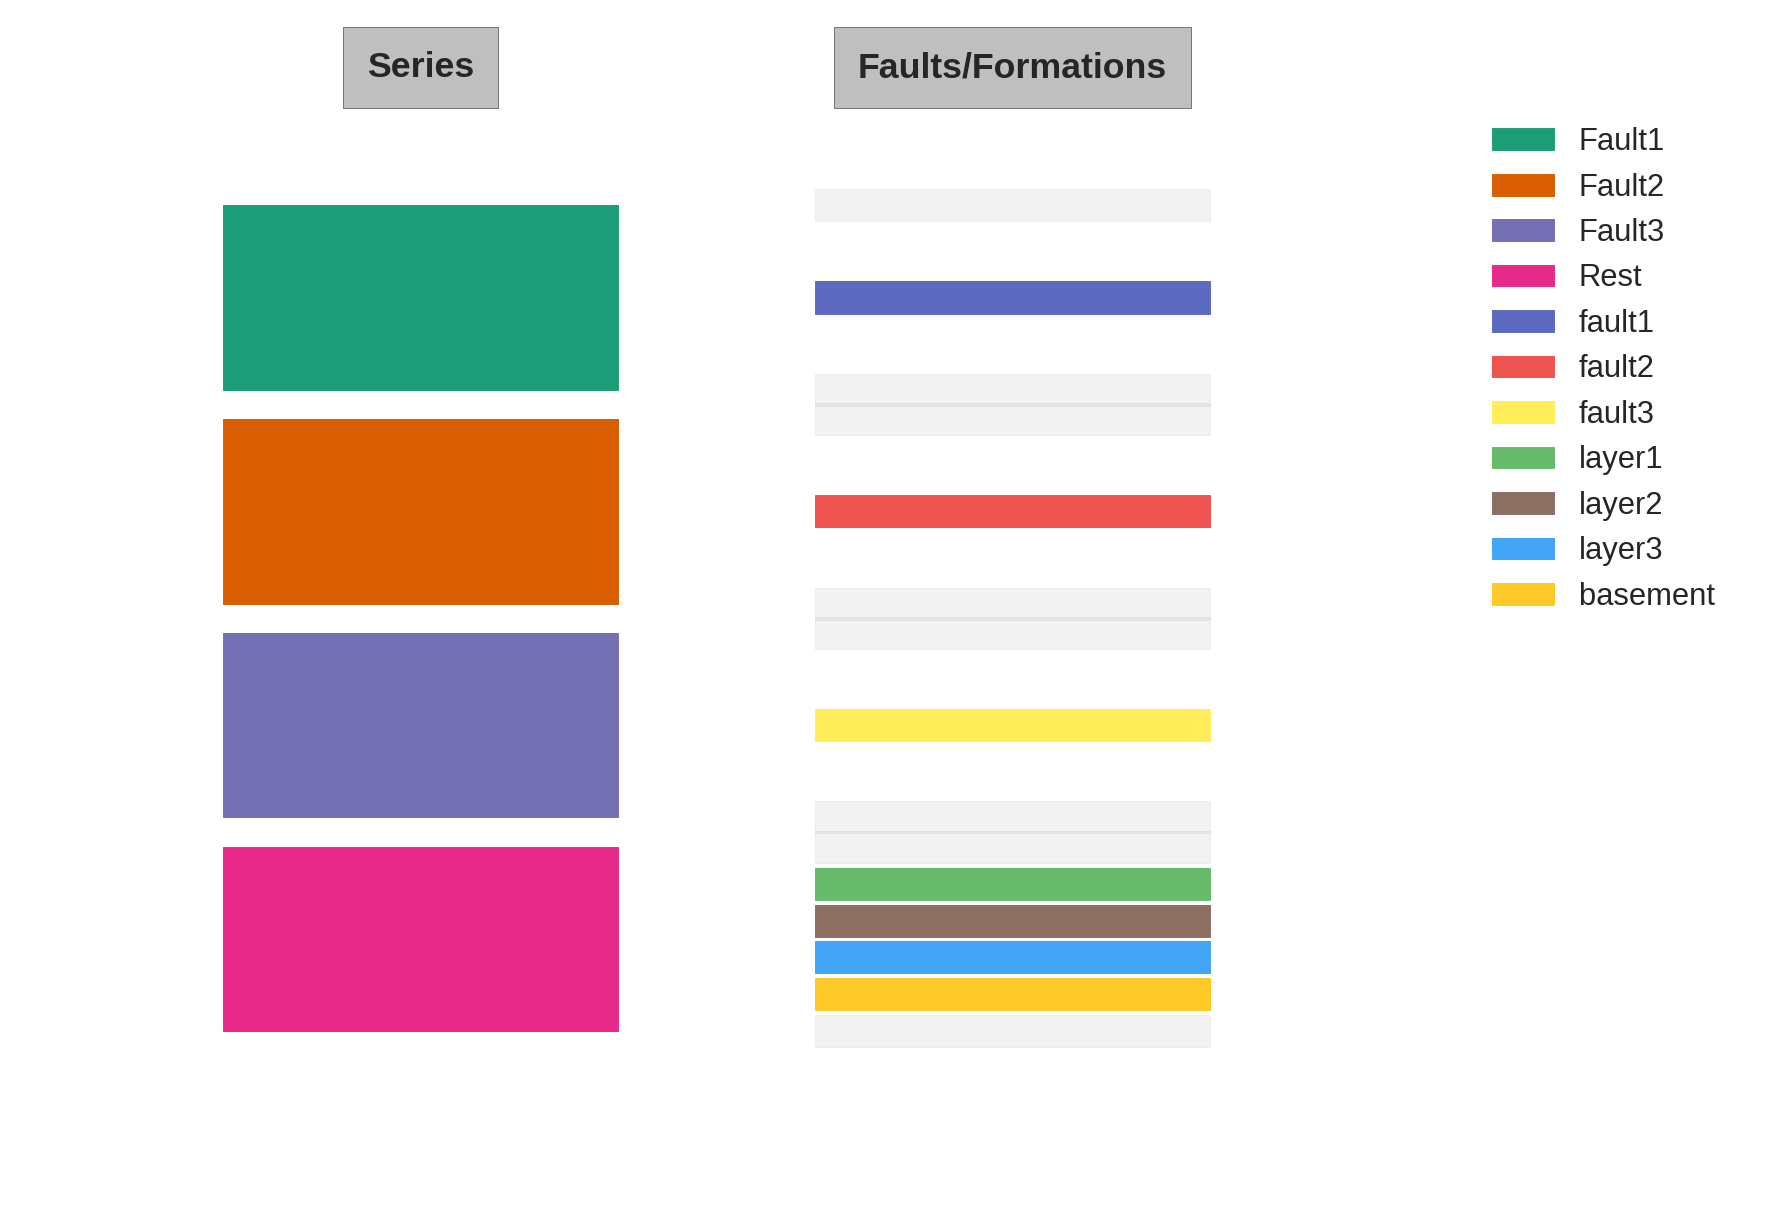

Fault1  Fault2  Fault3      Rest
0  fault1  fault2  fault3    layer1
1     NaN     NaN     NaN    layer2
2     NaN     NaN     NaN    layer3
3     NaN     NaN     NaN  basement

In [25]:
gp.set_series(geo_data, {'Fault1': 'fault1', 'Fault2': 'fault2', 'Fault3': 'fault3',
                         'Rest': ['layer1', 'layer2', 'layer3']}, verbose=1
             
             )

gp.get_data(geo_data, 'series')

In [26]:
interp_data = gp.InterpolatorData(geo_data, compile_theano=True,
                                  theano_optimizer='fast_compile',
                                  is_lith=True, is_fault=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  1


In [27]:
import copy
geo_data_i = copy.copy(geo_data)

In [28]:
# We instanciate a vtkPlot objecth
vtk_plot = gp.plotting.vtkPlot(geo_data_i)

# We call the real time plotter passing thhe interp_data
vtk_plot.plot_surfaces_3D_real_time(interp_data, size=(1920, 2160))

holding... Use vtk.resume to go back to the interactive window


In [29]:
vtk_plot.observe_df(geo_data_i, itype='interfaces')

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, precision=5, show_toolbar=True)

In [10]:
vtk_plot.observe_df(geo_data_i, itype='orientations')

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, precision=5, show_toolbar=True)

Not enough data to compute the model
Not enough data to compute the model
Not enough data to compute the model
Not enough data to compute the model
Not enough data to compute the model
Not enough data to compute the model


In [30]:
vtk_plot.observe_df(geo_data_i, itype='faults_relations')

../../gempy/data_management.py:376: UserWarning: for this itype Add Row does not work. If needed try using interfaces or orientationsinstead
  warnings.warn('for this itype Add Row does not work. If needed try using interfaces or orientations'


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, precision=5)

X         Y         Z formation  series  formation_number  \
0   0.361211  0.305656  0.736211    fault1  Fault1                 1   
1   2.373300  0.750100  0.736211    fault1  Fault1                 1   
2   0.638989  0.750100  0.291767    fault1  Fault1                 1   
3   0.638989  0.305656  0.291767    fault1  Fault1                 1   
4   0.305656  0.305656  0.708433    layer1    Rest                 4   
5   0.305656  0.750100  0.708433    layer1    Rest                 4   
6   0.527878  0.750100  0.625100    layer1    Rest                 4   
7   0.527878  0.305656  0.625100    layer1    Rest                 4   
8   0.750100  0.750100  0.597322    layer1    Rest                 4   
9   0.750100  0.305656  0.597322    layer1    Rest                 4   
10  0.277878  0.305656  0.597322    layer2    Rest                 5   
11  0.333433  0.305656  0.652878    layer2    Rest                 5   
12  0.333433  0.750100  0.652878    layer2    Rest                 5   
13  0.277878  0.750100  0.597322    layer2    Rest                 5   
14  0.750100  0.305656  0.319544    layer3    Rest                 6   
15  0.416767  0.750100  0.430656    layer3    Rest                 6   
16  0.416767  0.305656  0.430656    layer3    Rest                 6   
17  0.750100  0.750100  0.319544    layer3    Rest                 6   

    order_series  isFault                       annotations  formation_value  
0            1.0     True  ${\bf{x}}_{\alpha \,{\bf{1}},0}$                1  
1            1.0     True  ${\bf{x}}_{\alpha \,{\bf{1}},1}$                1  
2            1.0     True  ${\bf{x}}_{\alpha \,{\bf{1}},2}$                1  
3            1.0     True  ${\bf{x}}_{\alpha \,{\bf{1}},3}$                1  
4            4.0    False  ${\bf{x}}_{\alpha \,{\bf{4}},0}$                4  
5            4.0    False  ${\bf{x}}_{\alpha \,{\bf{4}},1}$                4  
6            4.0    False  ${\bf{x}}_{\alpha \,{\bf{4}},2}$                4  
7            4.0    False  ${\bf{x}}_{\alpha \,{\bf{4}},3}$                4  
8            4.0    False  ${\bf{x}}_{\alpha \,{\bf{4}},4}$                4  
9            4.0    False  ${\bf{x}}_{\alpha \,{\bf{4}},5}$                4  
10           4.0    False  ${\bf{x}}_{\alpha \,{\bf{5}},0}$                5  
11           4.0    False  ${\bf{x}}_{\alpha \,{\bf{5}},1}$                5  
12           4.0    False  ${\bf{x}}_{\alpha \,{\bf{5}},2}$                5  
13           4.0    False  ${\bf{x}}_{\alpha \,{\bf{5}},3}$                5  
14           4.0    False  ${\bf{x}}_{\alpha \,{\bf{6}},0}$                6  
15           4.0    False  ${\bf{x}}_{\alpha \,{\bf{6}},1}$                6  
16           4.0    False  ${\bf{x}}_{\alpha \,{\bf{6}},2}$                6  
17           4.0    False  ${\bf{x}}_{\alpha \,{\bf{6}},3}$                6

In [45]:
b

<pymc.distributions.new_dist_class.<locals>.new_class 'test' at 0x7fba52eadcc0>

In [12]:
vtk_plot.resume()

holding... Use vtk.resume to go back to the interactive window


In [9]:
vtk_plot.close()

#### Saving geo_data

In [14]:
gp.set_interfaces(geo_data, geo_data_i.interfaces)
gp.set_orientations(geo_data, geo_data_i.orientations)
geo_data.data_to_pickle('backup2.pickle')

In [34]:
lith_block, fault_block = gp.compute_model(interp_data)

../../gempy/gempy_front.py:919: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


<IPython.core.display.Javascript object>


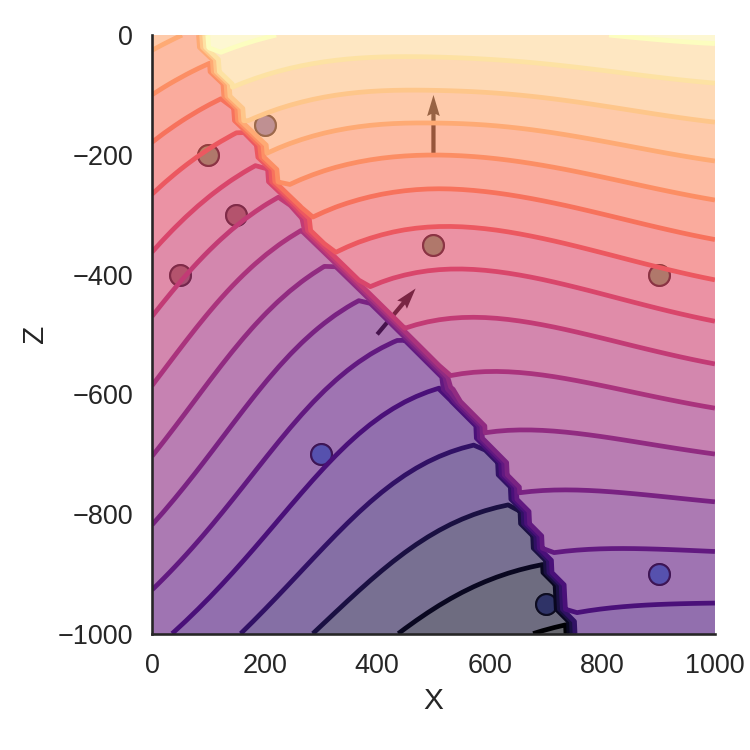

In [35]:
%matplotlib notebook
gp.plot_scalar_field(geo_data_i, lith_block[1], 25, plot_data=True)

../../gempy/gempy_front.py:895: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


<IPython.core.display.Javascript object>


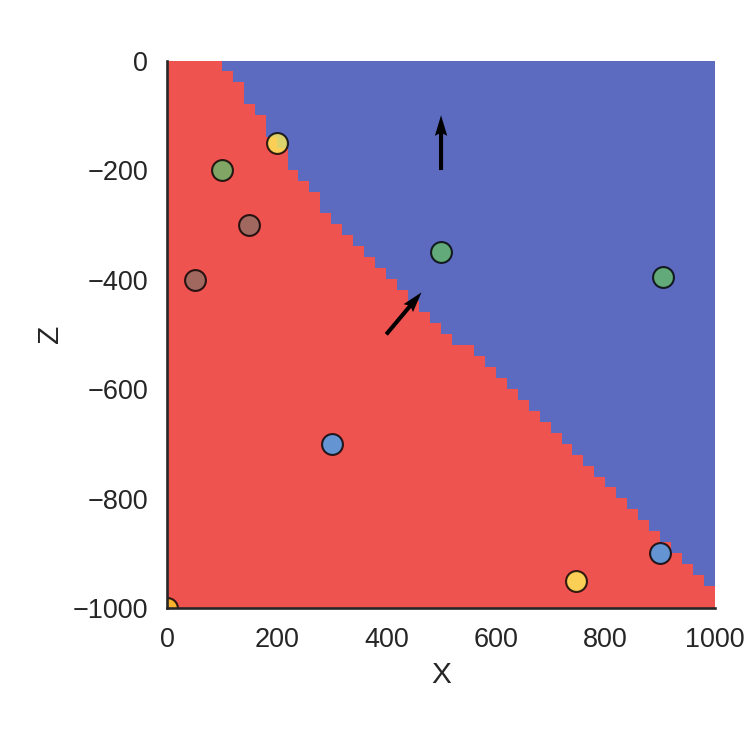

In [13]:
%matplotlib notebook
gp.plot_section(geo_data_i, fault_block[0], 25, plot_data=True)